In [67]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score, precision_score
from sklearn import preprocessing


import graphviz
from IPython.display import Image  
import pydotplus
from io import StringIO

import plotly_express as px

from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE

In [68]:
class AbstractClassificationProblem:
    labels = ['No Fraude', 'Fraude']

    def train(self):
        print("Comienza Entrenamiento")
        self.print_self()
        self.clf_model.fit(self.X_train, self.y_train)
        self.y_predict = self.clf_model.predict(self.X_test)
        print("Entrenado")
    
    def show_confusion_matrix(self):
        self.print_self()
        ConfusionMatrixDisplay.from_estimator(estimator=self.clf_model,
                                              X=self.X_test, 
                                              y=self.y_test,
                                              display_labels=self.labels)
        plt.show()
    
    def show_classification_report(self):
        self.print_self()
        print(classification_report(self.y_test, self.y_predict, target_names=self.labels))

    def accuracy(self):
        return accuracy_score(self.y_test, self.y_predict)
    
    def recall(self):
        return recall_score(self.y_test, self.y_predict)
    
    def precision_score(self):
        return precision_score(self.y_test, self.y_predict)
    
    def print_self(self):
        pass

class AbstractDecisionTree(AbstractClassificationProblem):
    criterion = ""
    tipo = ""
    
    def __init__(self, X, y, X_train, X_test, y_train, y_test, target, max_depth=5, min_samples_leaf=5):
        self.X_train = X_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_train = y_train
        self.clf_model = DecisionTreeClassifier(criterion=self.criterion, 
                                                random_state=42,
                                                max_depth=max_depth,
                                                min_samples_leaf=min_samples_leaf)

        self.target = list(df['isFraud'].unique())
        self.feature_names = list(X.columns)
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def show_matrix(self):
        dot_data = tree.export_graphviz(self.clf_model,
                                        out_file=None,
                                        feature_names=self.feature_names,
                                        class_names=str(self.target),
                                        filled=True,
                                        rounded=True,
                                        special_characters=True)
        dot_data = StringIO()
        export_graphviz(self.clf_model, 
                        out_file=dot_data, 
                        filled=True, 
                        rounded=True, 
                        special_characters=True,
                        feature_names=self.feature_names,
                        class_names=self.labels)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
        return Image(graph.create_png())
    
    def print_self(self):
        print("**", "Arbol de decision - " + self.tipo, "**")
        print('**', "max_depth=" + str(self.max_depth) + ",", "min_samples_leaf=" + str(self.min_samples_leaf), "**")


class GiniDecisionTree(AbstractDecisionTree):
    criterion = "gini"
    tipo = "Gini Index"

class InformationGainDecisionTree(AbstractDecisionTree):
    criterion = "entropy"
    tipo = "Information Gain"

# https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
class AbstractNeuralNetwork(AbstractClassificationProblem):
    solver = ''
    tipo = ''
    
    def __init__(self, X, y, X_train, X_test, y_train, y_test, alpha=1e-5, hidden_layer_sizes=(15,), max_iter=5000):
        self.X = X
        self.y = y
        
        # https://scikit-learn.org/stable/modules/preprocessing.html
        self.X_train = self._scale(X_train)
        self.X_test = self._scale(X_test)
        
        #https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
        self.y_train = y_train.values.ravel()

        self.y_test = y_test
        
        self.alpha = alpha
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter

        self.clf_model = MLPClassifier(solver=self.solver,
                                       alpha=alpha, 
                                       hidden_layer_sizes=hidden_layer_sizes, 
                                       random_state=42, 
                                       max_iter=max_iter)   
    
    def print_self(self):
        print("**", "Red Neuronal - " + self.tipo, "**")
        print("**", 
              "alpha=" + str(self.alpha), 
              "hidden_layer_sizes=" + str(self.hidden_layer_sizes), 
              "max_iter=" + str(self.max_iter), 
              "**")

    def _scale(self, X):
        scaler = preprocessing.StandardScaler().fit(X)
        return scaler.transform(X)


class LBFGSNeuralNetwork(AbstractNeuralNetwork):
    solver = 'lbfgs'
    tipo = "LBFGS"

class SGDNeuralNetwork(AbstractNeuralNetwork):
    solver = 'sgd'
    tipo = "SGD"

class AdamNeuralNetwork(AbstractNeuralNetwork):
    solver = 'adam'
    tipo = 'ADAM'

class Comparator:
    models = []
    
    def __init__(self, models):
        self.models = models
    
    def show_confusion_matrix(self):
        for model in self.models:
            model.show_confusion_matrix()
            print("\n")

    def show_classification_report(self):
        for model in self.models:
            model.show_classification_report()
            print("\n")

    def accuracy(self):
        for model in self.models:
            print(model.accuracy())
    
    def recall(self):
        for model in self.models:
            print(model.recall())
    
    def precision_score(self):
        for model in self.models:
            print(model.precision_score())

# ANALISIS DE DATOS

## Levantamos los datos

In [69]:
df = pd.read_csv("./Fraud.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Tamaño del dataset

In [70]:
df.shape

(6362620, 11)

## Tipos de los datos

In [71]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## Estadisticas descriptivas de los datos

In [72]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Se borran las columnas 'nameOrig' y 'nameDest'

In [73]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

## Revisamos si hay valores perdidos (None, NaN) en el resto del dataset

In [74]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Correlación de los datos

### Correlacion de los datos contra la variable 'isFraud'

In [75]:
df.corr()["isFraud"].sort_values()

newbalanceOrig   -0.008148
oldbalanceDest   -0.005885
newbalanceDest    0.000535
oldbalanceOrg     0.010154
step              0.031578
isFlaggedFraud    0.044109
amount            0.076688
isFraud           1.000000
Name: isFraud, dtype: float64

### Correlacion de los datos entre si

<AxesSubplot:>

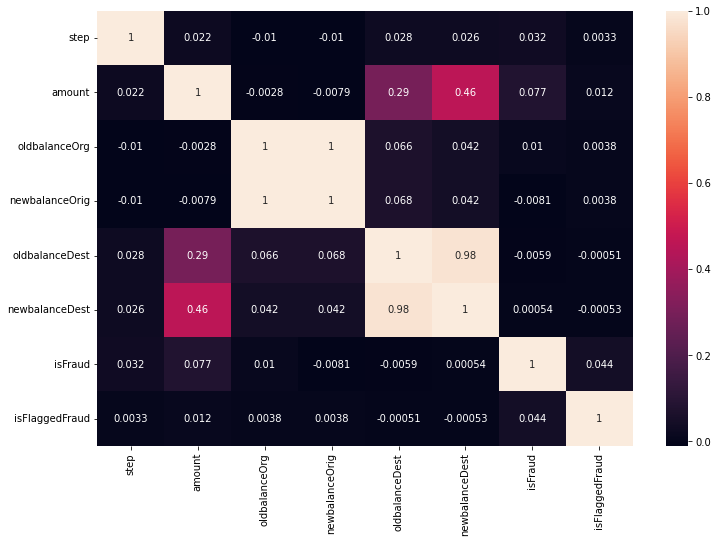

In [76]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)

## Cantidad de fraudes y no fraudes que hay en el dataset

In [77]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

## Cantidad de fraudes y no fraudes que hay en el dataset (Normalizado)

In [78]:
df["isFraud"].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

## Cantidad de tipos de transacciones que hay en el dataset

In [79]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

## Transacciones fraudulentas y no fraudulentas diferenciadas por su tipo

<AxesSubplot:xlabel='type', ylabel='count'>

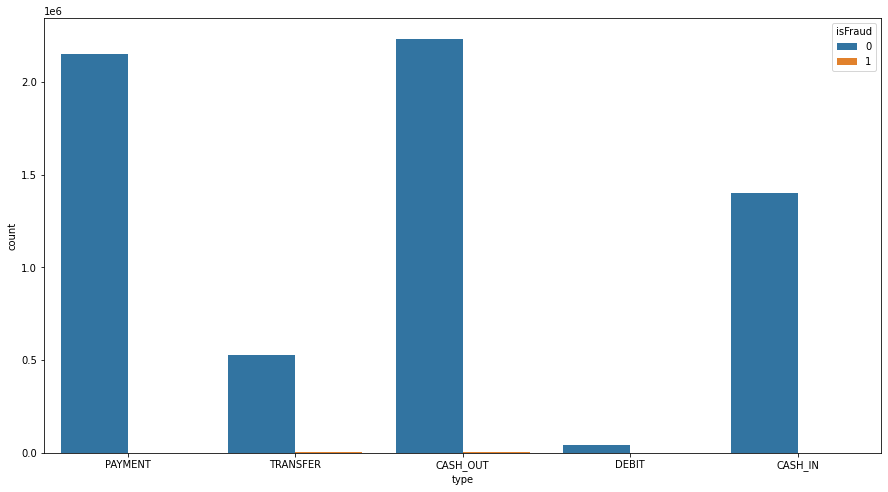

In [80]:
plt.figure(figsize=(15, 8))
sns.countplot(x="type", data=df, hue="isFraud")

## Porcentajes de transacciones fraudulentas de cada tipo de transaccion

In [81]:
# https://docs.python.org/3/library/collections.html#collections.Counter
df_type_fraud = pd.DataFrame(dict(Counter(df['type'])).items(), columns=['type', 'IsFraud'])

pie_porcentaje_transacciones_fraudulentas = px.pie(df_type_fraud, values="IsFraud", names='type', title='Transacciones Fraudulentas', color_discrete_sequence=px.colors.sequential.RdBu)
pie_porcentaje_transacciones_fraudulentas.show()

## Mapeo el type a numeros

In [82]:
mapping_type = {'CASH_IN': 0,'CASH_OUT': 1,'PAYMENT': 2,'TRANSFER': 3,'DEBIT': 4}
df['type_numeric'] = df.type.map(mapping_type)
df.drop('type', inplace=True, axis=1)

In [83]:
X = df.drop('isFraud',axis=1)
y = df[['isFraud']]

# Primeras pruebas con datos desbalanceados

## Separación de los datos de entrenamiento (80%) y datos para testing (20%)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Entreno el Arbol de Decision (Gini Impurity)

In [85]:
dtGini = GiniDecisionTree(X=X, 
                          y=y, 
                          X_train=X_train, 
                          X_test=X_test, 
                          y_train=y_train, 
                          y_test=y_test, 
                          target=df['isFraud'],
                          max_depth=5, 
                          min_samples_leaf=5)
dtGini.train()

Comienza Entrenamiento
** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **
Entrenado


### Medidas de performance

#### Matriz de Confusion

** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **


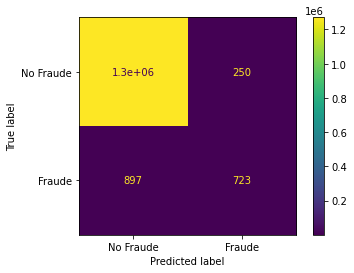

In [86]:
dtGini.show_confusion_matrix()

#### Reporte

In [87]:
dtGini.show_classification_report()

** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00   1270904
      Fraude       0.74      0.45      0.56      1620

    accuracy                           1.00   1272524
   macro avg       0.87      0.72      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Accuracy

In [88]:
dtGini.accuracy()

0.9990986417544974

#### Recall

In [89]:
dtGini.recall()

0.4462962962962963

#### Precision Score

In [90]:
dtGini.precision_score()

0.7430626927029804

### Impresion del Arbol

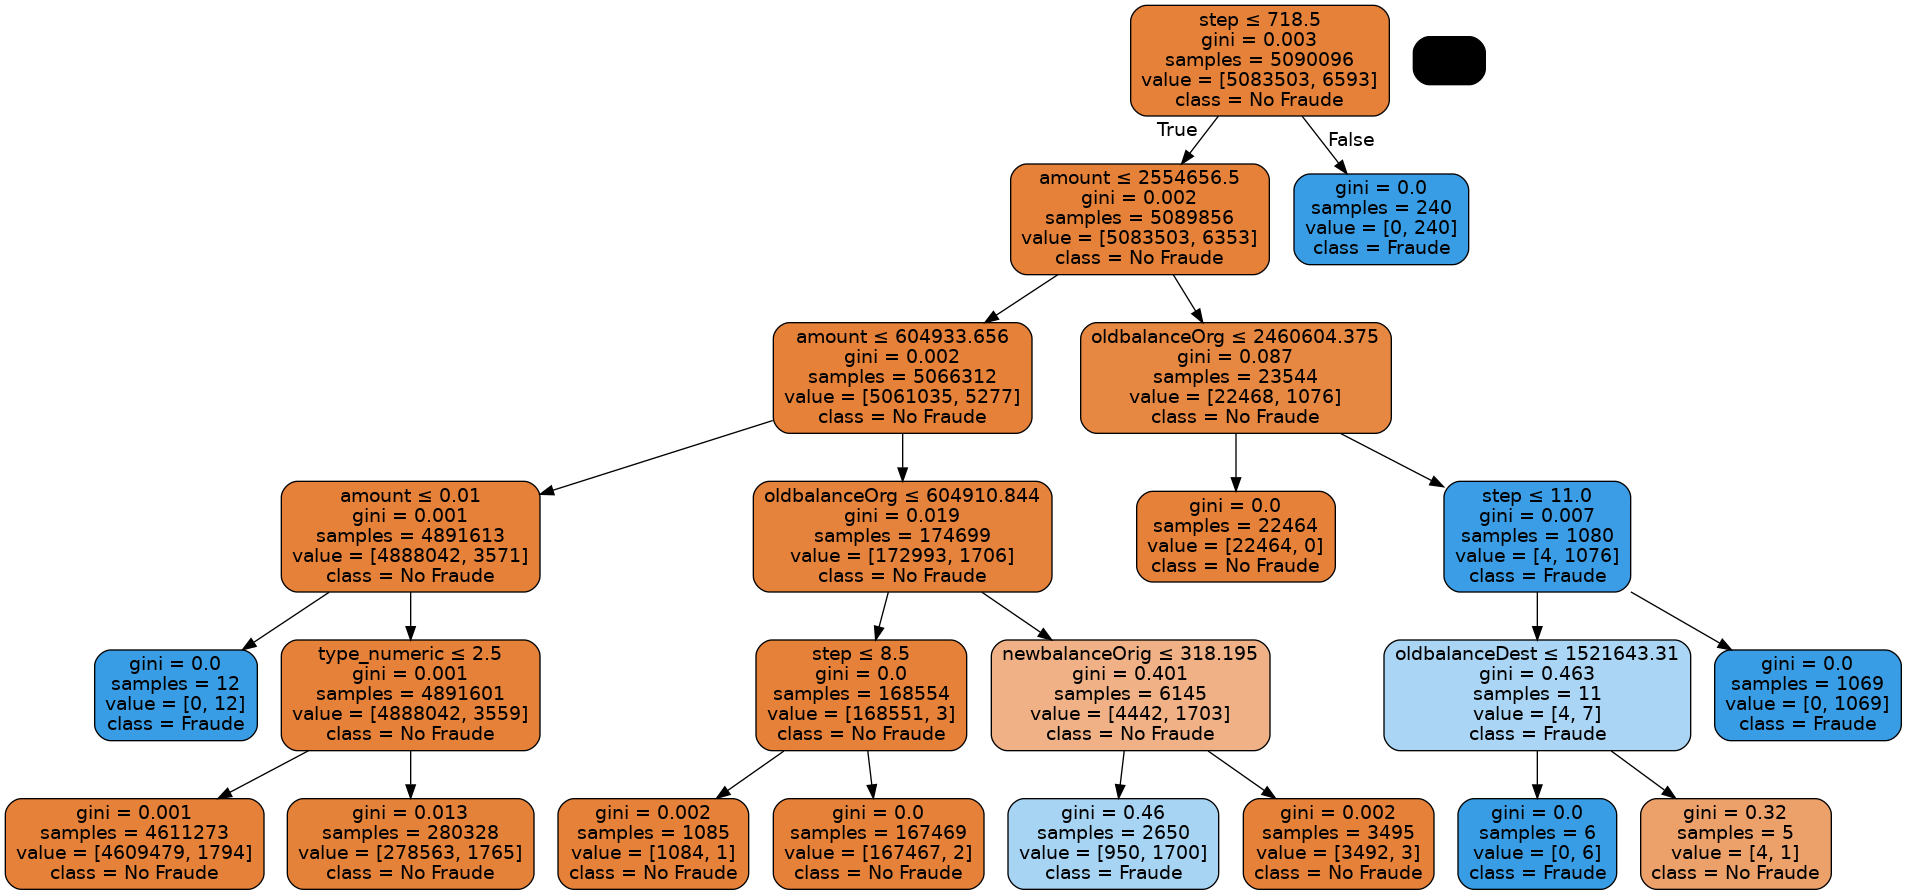

In [91]:
dtGini.show_matrix()

## Entreno el Arbol de Decision (Information Gain)

In [92]:
dtInfoGain = InformationGainDecisionTree(X=X, 
                                         y=y, 
                                         X_train=X_train, 
                                         X_test=X_test, 
                                         y_train=y_train, 
                                         y_test=y_test, 
                                         target=df['isFraud'],
                                         max_depth=5, 
                                         min_samples_leaf=5)
dtInfoGain.train()

Comienza Entrenamiento
** Arbol de decision - Information Gain **
** max_depth=5, min_samples_leaf=5 **
Entrenado


### Medidas de Performance

#### Matriz de Confusion

** Arbol de decision - Information Gain **
** max_depth=5, min_samples_leaf=5 **


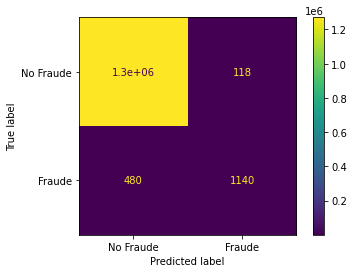

In [93]:
dtInfoGain.show_confusion_matrix()

#### Reporte

In [94]:
dtInfoGain.show_classification_report()

** Arbol de decision - Information Gain **
** max_depth=5, min_samples_leaf=5 **
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00   1270904
      Fraude       0.91      0.70      0.79      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.85      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Accuracy

In [95]:
dtInfoGain.accuracy()

0.9995300678022576

#### Recall

In [96]:
dtInfoGain.recall()

0.7037037037037037

#### Precision

In [97]:
dtInfoGain.precision_score()

0.9062003179650239

### Impresion del Arbol

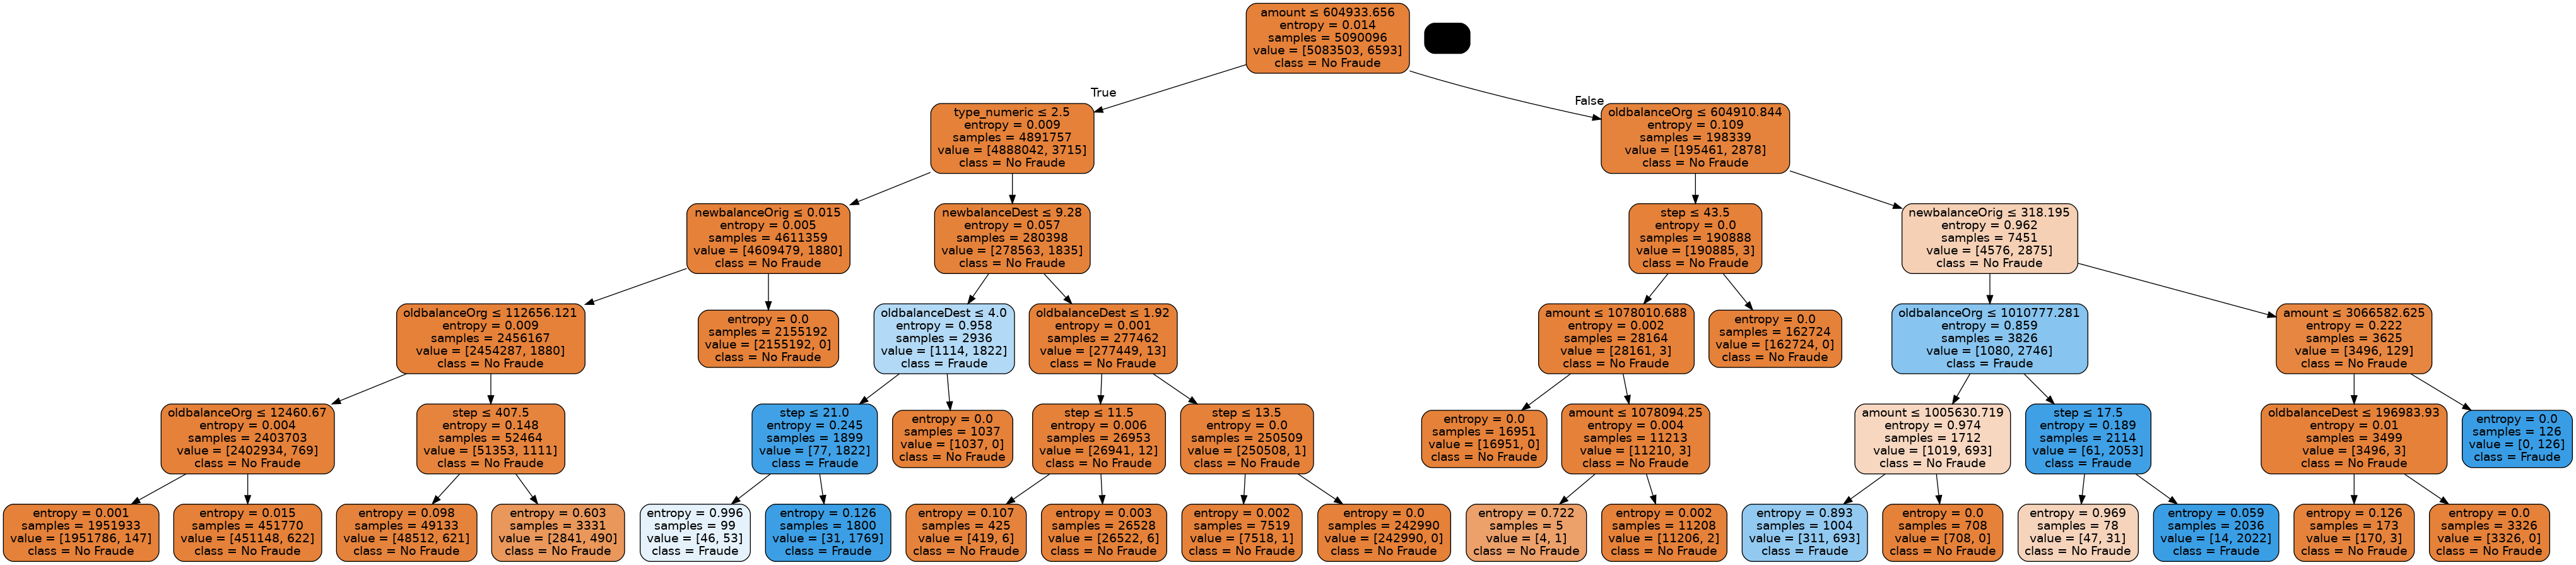

In [98]:
dtInfoGain.show_matrix()

## Entreno Red Neuronal

In [99]:
nn = LBFGSNeuralNetwork(X=X,
                        y=y,
                        X_train=X_train, 
                        X_test=X_test, 
                        y_train=y_train, 
                        y_test=y_test, 
                        alpha=1e-5, 
                        hidden_layer_sizes=(15,), 
                        max_iter=200)
nn.train()

Comienza Entrenamiento
** Red Neuronal - LBFGS **
** alpha=1e-05 hidden_layer_sizes=(15,) max_iter=200 **
Entrenado


### Medidas de Performance

#### Matriz de Confusion

** Red Neuronal - LBFGS **
** alpha=1e-05 hidden_layer_sizes=(15,) max_iter=200 **


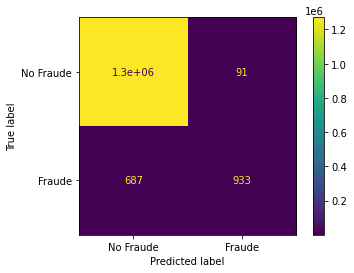

In [100]:
nn.show_confusion_matrix()

#### Reporte

In [101]:
nn.show_classification_report()

** Red Neuronal - LBFGS **
** alpha=1e-05 hidden_layer_sizes=(15,) max_iter=200 **
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00   1270904
      Fraude       0.91      0.58      0.71      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.79      0.85   1272524
weighted avg       1.00      1.00      1.00   1272524



#### Accuracy

In [102]:
nn.accuracy()

0.9993886166390575

#### Recall

In [103]:
nn.recall()

0.575925925925926

#### Precision

In [104]:
nn.precision_score()

0.9111328125

# Agrego un Comparador de modelos

In [105]:
dtGini = GiniDecisionTree(X=X, 
                          y=y, 
                          X_train=X_train, 
                          X_test=X_test, 
                          y_train=y_train, 
                          y_test=y_test, 
                          target=df['isFraud'],
                          max_depth=5, 
                          min_samples_leaf=5)
dtGini.train()

dtInfoGain = InformationGainDecisionTree(X=X, 
                                         y=y, 
                                         X_train=X_train, 
                                         X_test=X_test, 
                                         y_train=y_train, 
                                         y_test=y_test, 
                                         target=df['isFraud'],
                                         max_depth=5, 
                                         min_samples_leaf=5)
dtInfoGain.train()

nn = LBFGSNeuralNetwork(X=X,
                        y=y,
                        X_train=X_train, 
                        X_test=X_test, 
                        y_train=y_train, 
                        y_test=y_test, 
                        alpha=1e-5, 
                        hidden_layer_sizes=(15,), 
                        max_iter=200)
nn.train()

Comienza Entrenamiento
** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **
Entrenado
Comienza Entrenamiento
** Arbol de decision - Information Gain **
** max_depth=5, min_samples_leaf=5 **
Entrenado
Comienza Entrenamiento
** Red Neuronal - LBFGS **
** alpha=1e-05 hidden_layer_sizes=(15,) max_iter=200 **
Entrenado


In [106]:
models = [
    dtGini, dtInfoGain, nn
]

comparator = Comparator(models)

** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **


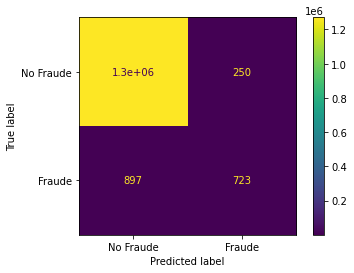



** Arbol de decision - Information Gain **
** max_depth=5, min_samples_leaf=5 **


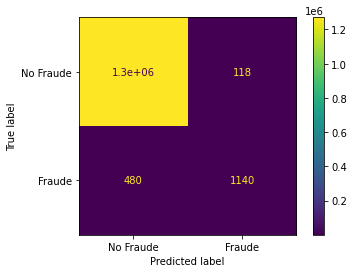



** Red Neuronal - LBFGS **
** alpha=1e-05 hidden_layer_sizes=(15,) max_iter=200 **


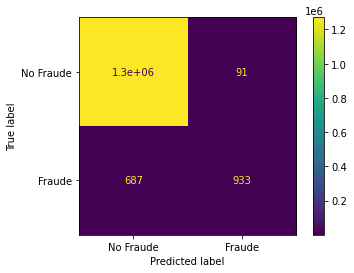

In [107]:
comparator.show_confusion_matrix()

In [108]:
comparator.show_classification_report()

** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00   1270904
      Fraude       0.74      0.45      0.56      1620

    accuracy                           1.00   1272524
   macro avg       0.87      0.72      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



** Arbol de decision - Information Gain **
** max_depth=5, min_samples_leaf=5 **
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00   1270904
      Fraude       0.91      0.70      0.79      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.85      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524



** Red Neuronal - LBFGS **
** alpha=1e-05 hidden_layer_sizes=(15,) max_iter=200 **
              precision    recall  f1-score   support

   No Fraude       1.00      1.00      1.00   12

In [109]:
comparator.accuracy()

0.9990986417544974
0.9995300678022576
0.9993886166390575


In [110]:
comparator.recall()

0.4462962962962963
0.7037037037037037
0.575925925925926


In [111]:
comparator.precision_score()

0.7430626927029804
0.9062003179650239
0.9111328125


# Primeras pruebas con datos Balanceados

In [112]:
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X, y)

In [113]:
len(X)

6362620

In [114]:
len(X_balanced)

12708814

In [115]:
y.value_counts()

isFraud
0          6354407
1             8213
dtype: int64

In [116]:
y_balanced.value_counts()

isFraud
0          6354407
1          6354407
dtype: int64

In [117]:
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [118]:
dtGiniBalanced = GiniDecisionTree(X=X, 
                                  y=y, 
                                  X_train=X_balanced_train, 
                                  X_test=X_balanced_test, 
                                  y_train=y_balanced_train, 
                                  y_test=y_balanced_test, 
                                  target=df['isFraud'],
                                  max_depth=5,
                                  min_samples_leaf=5)
dtGiniBalanced.train()

Comienza Entrenamiento
** Arbol de decision - Gini Index **
** max_depth=5, min_samples_leaf=5 **
Entrenado
